## Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import re
import pickle
import matplotlib.pyplot as plt
import os
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

### Set threshold for Different Classes

In [2]:
VNEGATIVE_UPPER_BOUND = -2
NEGATIVE_UPPER_BOUND = -0.5
NEUTRAL_UPPER_BOUND = 0.5
POSITIVE_UPPER_BOUND = 2

##### FileNames for training Data

In [3]:
STOCK_PRICES_CSV = "FYP_Stock.csv"
NEWS_CSV = "news.csv"
global_accuracy = []

In [4]:
def getChangePercentage(dataFrame):
    
    change = list(dataFrame['CHANGE_PERCENT'])
    
    def formatChangePercent(s):
        
        pattern = r'([-+]?[0-9]{1,2}\.[0-9]{1,2}%)'
        matches = re.findall(pattern,s)[0]
        
        floatPattern = r'[-+]?[0-9]{1,2}\.[0-9]{1,2}'
        floatNum = re.findall(floatPattern,matches)[0]
        
        floatNum = float(floatNum)
        
        return floatNum
    
    change = list(map(formatChangePercent,change))
    
    dataFrame['PercentChange'] = change

In [5]:
def classify(value):
        
    if value < VNEGATIVE_UPPER_BOUND:
        return -2
    elif value < NEGATIVE_UPPER_BOUND:
        return -1
    elif value <= NEUTRAL_UPPER_BOUND:
        return 0
    elif value <= POSITIVE_UPPER_BOUND:
        return 1
    return 2

In [6]:
def classifyStockData(dataFrame):
    
    percentChange = dataFrame['PercentChange']
    
    dataFrame['Class'] = list(map(classify,percentChange))

In [7]:
def processStockMarketData(fileName):
    dataFrame = pd.read_csv(fileName,index_col=0,parse_dates=[2])
        
    company_stock_daily = dict()
        
    company_names = list(dataFrame['NAME'].unique())
        
    for company in company_names:
            
        company_stock_daily[company] = dataFrame.loc[dataFrame['NAME'] == company]
        company_stock_daily[company] = company_stock_daily[company].sort_values(by='DATE_OF_NEWS')
        getChangePercentage(company_stock_daily[company])
        classifyStockData(company_stock_daily[company])
        
    return company_stock_daily
    

In [8]:
def cleanText(text):
    
    # Removing special characters and numbers
    pattern = r'[^a-zA-Z]'
    text = re.sub(pattern," ",text)
    text = text.lower()
    
    
    ## Word tokenize
    words = word_tokenize(text)
    
    ## Removing stopwords
    stopword = set(stopwords.words('english'))
    words = [ word for word in words if word not in stopword and len(word)>3 ]
    

    ## Stemming
    stemmer = PorterStemmer()
    words = [ stemmer.stem(word) for word in words ]
    
    
    return " ".join(words)

In [24]:
cleanText("Go long in Tata Consultancy Services advises Siddarth Bhamre")

'long tata consult servic advis siddarth bhamr'

In [25]:
cleanText("Life Insurace Company trimmed stake in Tata Group cos with Cyrus Mistry at helm")

'life insurac compani trim stake tata group cyru mistri helm'

In [26]:
cleanText('Infosys opens special centre dedicated to Research & Development in Hyderabad')

'infosi open special centr dedic research develop hyderabad'

In [13]:
def loadNewsData(fileName):
    
    dataFrame = pd.read_csv(fileName,parse_dates=['date'])
    
    dataFrame['name'] = list(map(lambda x: x.replace('_',' '),dataFrame['name']))
    
    dataFrame['cleaned_headline'] = list(map(lambda x: cleanText(x),dataFrame['headline']))
    
    
    company_news = dict()
        
    company_names = list(dataFrame['name'].unique())
        
    for company in company_names:
            
        company_news[company] = dataFrame.loc[dataFrame['name'] == company]
        company_news[company] = company_news[company].sort_values(by='date')

    return company_news

In [14]:
def getData():

    stock = processStockMarketData(STOCK_PRICES_CSV)
    news = loadNewsData(NEWS_CSV)

    stock_keys = set(sorted(stock.keys()))
    news_keys = set(sorted(news.keys()))

    for name in stock_keys:
        if name not in news_keys:
            del stock[name]
    for name in news_keys:
        if name not in stock_keys:
            del news[name]
        elif news[name].shape[0]<400:
            
            print(name,news[name].shape)
            
            del news[name]
            del stock[name]

    return stock,news

In [15]:
def getClassFromAverageChange(dataFrame,dt):
    
    start_date = dt
    end_date = dt + timedelta(days=8)
    
    condition1 = dataFrame["DATE_OF_NEWS"]>=start_date
    condition2 = dataFrame["DATE_OF_NEWS"]<end_date
    
    bothCondition = condition1 & condition2
    
    values = dataFrame.loc[bothCondition]
    
    changes = list(values["PercentChange"])
    
    if(len(changes)==0):
        return None
    
    averageChange = sum(changes)/len(changes)
    return classify(averageChange)

def getAverageChange(dataFrame,dt):
    
    start_date = dt
    end_date = dt + timedelta(days=8)
    
    condition1 = dataFrame["DATE_OF_NEWS"]>=start_date
    condition2 = dataFrame["DATE_OF_NEWS"]<end_date
    
    bothCondition = condition1 & condition2
    
    values = dataFrame.loc[bothCondition]
    
    changes = list(values["PercentChange"])
    
    if(len(changes)==0):
        return None
    
    averageChange = sum(changes)/len(changes)
    return averageChange

In [16]:
def saveModel(name,model):
    
    if not os.path.exists("models"):
        os.mkdir("models")
    
    name = name.replace(' ','_')
    name = "models/"+name+".model"
    pickle.dump(model,open(name,"wb"))


def trainCompany(name,news,stock):
    
    global global_accuracy
    
    targetVariable = []
    preprocessed_text = []
    
    for index,row in news.iterrows():
        
        dt = row['date']
        text_original = row['headline']
        text = row['cleaned_headline']
        sentiment = getClassFromAverageChange(stock,dt)
        
        if sentiment == None:
            continue
    
        if sentiment==1:
            print(text_original,sentiment,name,sep="\n",end="\n\n\n")
    
    
        targetVariable.append(sentiment)
        preprocessed_text.append(text)
    
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(preprocessed_text)
    
    saveModel(name+"_TFIDF",vectorizer)
    
    
    X_train,X_test,y_train,y_test = train_test_split(X,targetVariable,test_size = 0.15)
    
    clf = RandomForestClassifier(random_state=192)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    global_accuracy.append(accuracy_score(y_test,y_pred)*100)
    
    saveModel(name+"_RFV",clf)
    
    print("Score for %s is %.2f%%"%(name,accuracy_score(y_test,y_pred)*100))
    
    return 50.0#clf.oob_score_
    

def train(news,stock):
    
    scores = []
    
    for name in news.keys():
        score = trainCompany(name,news[name],stock[name])
        scores.append(score)

    print(sum(scores)/len(scores))
        

global_accuracy = []
y,x = getData()

tempx,tempy = x,y

train(x,y)

TCS looks attractive says Hemant Thukral
1
TCS


TCS Infosys visa issue Govt to intervene when required
1
TCS


Prefer Infosys HCL Technologies TCS Mayuresh Joshi
1
TCS


TCS opens special centre dedicated to RD in Hyderabad
1
TCS


Prefer Infosys Persistent Systems R Sreesankar
1
TCS


Indian IT cos fully compliant with US visa norms Nasscom
1
TCS


Buy TCS target Rs 2640 Rahul Mohindar
1
TCS


Buy TCS says Devang Mehta
1
TCS


Analysts still bullish on TCS post Q1 cut rev estimates
1
TCS


Dipan Mehta negative on Infosys HCL Tech Tech Mahindra
1
TCS


Accumulate TCS target of Rs 2620 Emkay
1
TCS


Cautious on IT sector sell TCS Nirmal Bang
1
TCS


Short TCS at around Rs 2525 buy 2600 Call TS Harihar
1
TCS


Maintain cautious view on IT sector Girish Pai
1
TCS


Confident of achieving better than industry growth TCS CFO
1
TCS


Buy TCS target of Rs 2780 P Lilladher
1
TCS


Prefer largecap IT over midcap IT Hemindra Hazari
1
TCS


TCS Q1 net falls 3.3 but beats forecast  revenue up 3.5

US visa probe to include global IT firms norms to get stricter Sources
1
TCS


Buy TCS HCL Tech Kotak Bank REC sell Vedanta Zee Entertainment Sukhani
1
TCS


South Africas Mercantile Bank uses TCS solution
1
TCS


Union Minister Ravi Shankar Prasad inaugurates BPS centre set up by TCS
1
TCS


Nine of 10 most valued firms add Rs 36K cr to m-cap
1
TCS


TCS to commence Rs 16000 cr buyback from May 18
1
TCS


Brigade Group deal to lease 3.75 L sq ft office space to TCS
1
TCS


Accumulate Tata Consultancy Services Ltd target of Rs 2675 KRChoksey
1
TCS


Zions Bancorporation goes live on TCS BaNCS Core Banking software
1
TCS


Hold Tata Consultancy Services  target of Rs 2400 ICICI Direct
1
TCS


TCS results IIP inflation data to steer market this week
1
TCS


Excl How Chandrasekaran is trying to bring consolidation synergy and scale in Tata Group
1
TCS


TCS Q2 PAT seen up 3.7 QoQ to Rs. 6162.2 cr Kotak
1
TCS


Hold TCS says Sandeep Wagle
1
TCS


Expect constant currency revenue growth of 

/home/akash/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
def loadModel(name):
    
    name = name.replace(" ","_")
    name = "models/"+name+".model"
    
    return pickle.load(open(name, 'rb'))


def getClassName(i):
    return (
        "Very Negative",
        "Negative",
        "Neutral",
        "Positive",
        "Very Positive"
    )[i+2]


def predictClassId(name,text):
    
    vectorizer = loadModel(name+"_TFIDF")
    clf = loadModel(name+"_RFV")
    
    text = cleanText(text)
    
    X = vectorizer.transform([text])
    return clf.predict(X)[0]


def predict(name,text):
    
    vectorizer = loadModel(name+"_TFIDF")
    clf = loadModel(name+"_RFV")
    
    text = cleanText(text)
    
    X = vectorizer.transform([text])
    return list(map(getClassName,clf.predict(X)))

In [18]:
predict("TCS","Go long in TCS advises Siddarth Bhamre")

['Positive']

In [19]:
predict("TCS","LIC trimmed stake in Tata Group cos with Cyrus Mistry at helm")

['Neutral']

In [20]:
predict("TCS","Tata group companies lose over Rs 26000 cr in mcap in 3 days")

['Negative']

In [21]:
tempy["TCS"].head(5)

,NAME,DATE_OF_NEWS,OPEN_PRICE,CLOSE_PRICE,HIGH_PRICE,LOW_PRICE,CHANGE_PERCENT,VOLUME,PercentChange,Class
0,TCS,2014-05-06,"1,106.85","1,099.45","1,110.80","1,095.00",-7.40 (-0.67%),"9,61,232",-0.67,-1
1,TCS,2014-05-08,"1,082.55","1,081.03","1,090.90","1,073.83",-1.75 (-0.16%),"26,06,900",-0.16,0
2,TCS,2014-05-09,"1,076.00","1,079.95","1,092.35","1,076.00",-1.08 (-0.10%),"17,99,440",-0.10,0
3,TCS,2014-05-13,"1,082.90","1,105.48","1,119.50","1,082.90",+25.80 (+2.39%),"25,47,484",2.39,2
4,TCS,2014-05-15,"1,108.05","1,096.58","1,112.50","1,085.58",-11.47 (-1.04%),"25,20,196",-1.04,-1


(693, 4)
(754, 10)
(172, 7)


/home/akash/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/akash/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/akash/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/akash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


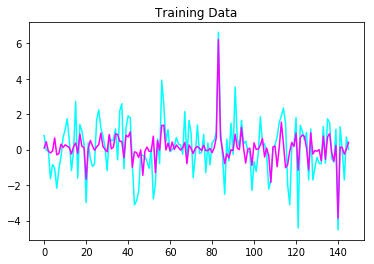

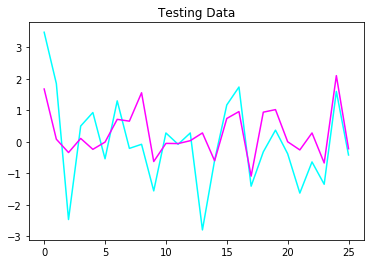

[[9 6]
 [2 9]]
Root mean Square error is 1.29


In [22]:
def getDataForSecondPhase(name,news,stock):
 
    print(news.shape)
    print(stock.shape)

    def getNumeric(s):
        
        s = s.replace(",","")
        s = s.replace(" ","")
        return float(s)


    newarr = []
    
    for date in news["date"].unique():
        
        if date not in stock["DATE_OF_NEWS"].unique():
            continue
        
        arr = []
        news_data = news.loc[news["date"]==date]
        stock_data = stock.loc[stock["DATE_OF_NEWS"]==date]
        
        if stock_data.shape[0]!=1:
            continue
        
        for headline in news_data["cleaned_headline"]:
            arr.append(predictClassId(name,headline))
            
        if len(arr)>0:
        
            arr = [ sum(arr)/len(arr) ]
            arr.append(getNumeric(stock_data["OPEN_PRICE"].values[0]))
            arr.append(getNumeric(stock_data["CLOSE_PRICE"].values[0]))
            arr.append(getNumeric(stock_data["HIGH_PRICE"].values[0]))
            arr.append(getNumeric(stock_data["LOW_PRICE"].values[0]))
            
            strVolume = stock_data["VOLUME"].values[0]
            strVolume = strVolume.replace(",","")
            strVolume = strVolume.replace(" ","")
            
            arr.append(int(strVolume))
            arr.append(stock_data["PercentChange"].values[0])
            
    
        newarr.append(arr)
        
        columns = ["average news sentiment","Opeining","Closing","High","Low","Volume","Change Percent"]
    
    return pd.DataFrame.from_records(newarr,columns=columns)
            

def trainSecondPhase(data):
    
    print(data.shape)
    
    regressor = MLPRegressor()
    
    X = data.drop(columns=["Change Percent"])
    y = data["Change Percent"]
    
    
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=.15)
    
    
    scalar = StandardScaler()
    
    Xtrain = scalar.fit_transform(Xtrain)
    
    regressor.fit(Xtrain,ytrain)
    
    
    
    Xtest1 = scalar.transform(Xtest)
    ytest1 = ytest
    
    
    pred = regressor.predict(Xtrain)
    
    plt.plot(range(len(pred)),ytrain,c="cyan")
    plt.plot(range(len(pred)),pred,c="magenta")
    plt.title('Training Data')
    plt.savefig('training.jpg')
    plt.show()
    
    
    pred = regressor.predict(Xtest1)
    
    plt.figure(1)
    plt.plot(range(len(pred)),ytest1,c="cyan")
    plt.plot(range(len(pred)),pred,c="magenta")
    plt.title('Testing Data')
    plt.savefig('testing.jpg')
    plt.show()
    
    directionOnlyTrue = [ -1 if x<0 else ( 1 if x>0 else 0 ) for x in ytest1 ]
    directionOnlyPred = [ -1 if x<0 else ( 1 if x>0 else 0 ) for x in pred ]
    
    print(confusion_matrix(directionOnlyTrue,directionOnlyPred))
    
    print("Root mean Square error is %.2f"%(mean_squared_error(ytest,pred)))
    
    
data = getDataForSecondPhase("TCS",x["TCS"],y["TCS"])
trainSecondPhase(data)

In [23]:
x11 = pd.DataFrame(StandardScaler().fit_transform(data.drop(columns=["average news sentiment"])),columns=data.columns[1:])
x11['average news sentiment'] = data['average news sentiment']
x11.head(30)

/home/akash/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/akash/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Opeining,Closing,High,Low,Volume,Change Percent,average news sentiment
0,-0.311763,-0.316318,-0.331618,-0.310225,-0.053092,-0.072496,0.333333
1,-0.321411,-0.303118,-0.333709,-0.285222,-0.714241,0.144991,0.500000
2,-0.208550,-0.233451,-0.236884,-0.192900,-0.365423,-0.566785,0.000000
3,-0.205092,-0.154433,-0.173776,-0.169494,-0.707769,1.041302,0.000000
4,-0.139378,-0.182557,-0.182863,-0.142931,-0.620421,-0.434974,-1.000000
5,-0.175238,-0.080732,-0.107061,-0.125767,-0.758951,0.698595,0.000000
6,-0.143091,-0.150766,-0.149073,-0.125395,0.021904,-0.579966,0.000000
7,-0.148479,-0.283868,-0.191338,-0.262560,0.687517,-1.891479,0.166667
8,-0.366191,-0.307591,-0.334971,-0.320628,-0.181806,0.889720,1.000000
9,-0.319591,-0.241224,-0.278427,-0.274931,-0.327226,1.173113,0.000000
